# Import Packages and Reading of Data

In [16]:
import time
import warnings
import pickle
import shap

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBClassifier, plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, RepeatedKFold
from xgboost import plot_importance
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

In [15]:
metadata_dataset = pd.read_csv('metadata_dataset.csv')
metadata_dataset

,protected,verified,location,followers_count,following_count,tweet_count,listed_count,has_profile_image,isBot,un_no_of_char,un_special_char,name_no_of_char,name_special_char,des_no_of_usertags,des_no_of_hashtags,des_external_links,has_description,has_url
0,0,0,1,1959,2708,405158,157,1,0,6,0,12,0,0,0,0,1,1
1,0,0,0,371,0,33172,10,1,0,13,0,14,0,0,0,0,1,1
2,0,0,0,36,0,548,0,1,1,13,1,16,0,0,0,0,1,0
3,0,0,1,30,148,93,1,1,1,12,0,12,0,0,0,0,1,1
4,0,0,1,1089,2283,9098,34,1,0,10,0,14,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20284,0,0,1,72,76,4161,1,1,0,11,0,12,0,0,0,0,0,0
20285,0,0,0,314,107,20915,9,1,0,13,1,14,0,0,0,1,1,1
20286,0,0,1,2981,2523,4991,46,1,0,14,0,16,0,0,3,1,1,1
20287,0,0,0,170,180,7820,4,1,0,11,0,12,0,0,0,0,1,0


# Slicing Based Model Evaluation
1. Random Forest Classifier
2. XGBoost Classifier

In [19]:
rf_classifier = RandomForestClassifier(bootstrap = False, 
                                       max_depth = 40, 
                                       max_features = "auto", 
                                       min_samples_split = 10, 
                                       n_estimators = 10)

In [20]:
# Best Hyperparameters: {'colsample_bytree': 0.7, 'eta': 0.1, 'max_depth': 25, 'subsample': 0.8}
def get_xgb_classifier(weight_train):
    classifier = XGBClassifier(gamma = 0.1,
                               alpha = 0.5,
                               max_depth = 25, 
                               eta = 0.1, 
                               subsample = 0.8,
                               colsample_bytree = 0.7,
                               scale_pos_weight = weight_train,
                               objective = "binary:logistic",
                               eval_metric = "logloss")
    return classifier

In [21]:
numeric_variables = ['followers_count', 'following_count', 'listed_count', 'tweet_count', 'un_no_of_char','name_no_of_char', 'des_no_of_usertags', 'des_no_of_hashtags']

## 01 verification
* Random Forest Classifier
* XGBoost Classifier

In [22]:
print("Number of Verified Accounts: " + str(len(metadata_dataset[metadata_dataset['verified'] == 1].index)))
print("Number of Non-Verified Accounts: " + str(len(metadata_dataset[metadata_dataset['verified'] == 0].index)))

verified_accounts_dataset = metadata_dataset[metadata_dataset['verified'] == 1]
non_verified_accounts_dataset = metadata_dataset[metadata_dataset['verified'] == 0]

# Getting X and y
x_verified = verified_accounts_dataset.drop(columns = ['isBot'])
y_verified = verified_accounts_dataset['isBot']

# Split into training and testing sets before scaling the variables and performing one hot encoding to avoid data leakage
x_train_verified, x_test_verified, y_train_verified, y_test_verified = train_test_split(x_verified, y_verified, test_size = 0.2, random_state=101)
print("Train set (verified):", x_train_verified.shape, y_train_verified.shape)
print("Test set (verified):", x_test_verified.shape, y_test_verified.shape)

scaler_verified = StandardScaler()
x_train_verified[numeric_variables] = scaler_verified.fit_transform(x_train_verified[numeric_variables])
x_test_verified[numeric_variables] = scaler_verified.transform(x_test_verified[numeric_variables])

# Getting X and y
x_non_verified = non_verified_accounts_dataset.drop(columns = ['isBot'])
y_non_verified = non_verified_accounts_dataset['isBot']

# Split into training and testing sets before scaling the variables and performing one hot encoding to avoid data leakage
x_train_non_verified, x_test_non_verified, y_train_non_verified, y_test_non_verified = train_test_split(x_non_verified, y_non_verified, test_size = 0.2, random_state=101)
print("Train set (non-verified):", x_train_non_verified.shape, y_train_non_verified.shape)
print("Test set (non-verified):", x_test_non_verified.shape, y_test_non_verified.shape)

scaler_non_verified = StandardScaler()
x_train_non_verified[numeric_variables] = scaler_non_verified.fit_transform(x_train_non_verified[numeric_variables])
x_test_non_verified[numeric_variables] = scaler_non_verified.transform(x_test_non_verified[numeric_variables])

Number of Verified Accounts: 1071
Number of Non-Verified Accounts: 19218
Train set (verified): (856, 17) (856,)
Test set (verified): (215, 17) (215,)
Train set (non-verified): (15374, 17) (15374,)
Test set (non-verified): (3844, 17) (3844,)


### verified - RF

In [23]:
%%time

# Fit Model
rf_model_verified = rf_classifier.fit(x_train_verified, np.ravel(y_train_verified))

Wall time: 58.3 ms


In [24]:
%%time

# y_prediction for the verified RF model
y_pred_verified_rf = rf_model_verified.predict(x_test_verified)

Wall time: 10.6 ms


In [25]:
# Metrics
accuracy = metrics.accuracy_score(y_test_verified, y_pred_verified_rf)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test_verified, y_pred_verified_rf)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test_verified, y_pred_verified_rf)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test_verified, y_pred_verified_rf)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test_verified, y_pred_verified_rf)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test_verified, y_pred_verified_rf)
print(f'Recall: {recall}')
report = metrics.classification_report(y_test_verified, y_pred_verified_rf)
print(f'Classification Report: \n {report}')

Accuracy: 0.813953488372093
Log Loss: 6.425856054747578
ROC AUC: 0.6861169345446075
F1-score: 0.5348837209302327
Precision: 0.696969696969697
Recall: 0.4339622641509434
Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.94      0.88       162
           1       0.70      0.43      0.53        53

    accuracy                           0.81       215
   macro avg       0.77      0.69      0.71       215
weighted avg       0.80      0.81      0.80       215



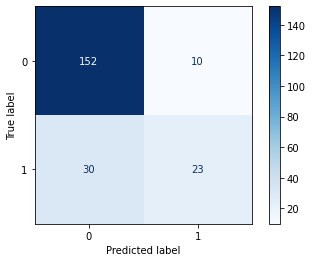

In [26]:
# Confusion Matrix Plot
metrics.plot_confusion_matrix(rf_model_verified, x_test_verified, y_test_verified, cmap = "Blues")
plt.show()

### non-verified - RF

In [27]:
%%time

# Fit Model
rf_model_non_verified = rf_classifier.fit(x_train_non_verified, np.ravel(y_train_non_verified))

Wall time: 257 ms


In [28]:
%%time

# y_prediction for the non verified RF model
y_pred_non_verified_rf = rf_model_non_verified.predict(x_test_non_verified)

Wall time: 8.72 ms


In [29]:
# Metrics
accuracy = metrics.accuracy_score(y_test_non_verified, y_pred_non_verified_rf)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test_non_verified, y_pred_non_verified_rf)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test_non_verified, y_pred_non_verified_rf)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test_non_verified, y_pred_non_verified_rf)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test_non_verified, y_pred_non_verified_rf)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test_non_verified, y_pred_non_verified_rf)
print(f'Recall: {recall}')
report = metrics.classification_report(y_test_non_verified, y_pred_non_verified_rf)
print(f'Classification Report: \n {report}')

Accuracy: 0.9427679500520292
Log Loss: 1.9767372484726153
ROC AUC: 0.9125666434121154
F1-score: 0.8895582329317269
Precision: 0.9375661375661376
Recall: 0.8462273161413563
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      2797
           1       0.94      0.85      0.89      1047

    accuracy                           0.94      3844
   macro avg       0.94      0.91      0.93      3844
weighted avg       0.94      0.94      0.94      3844



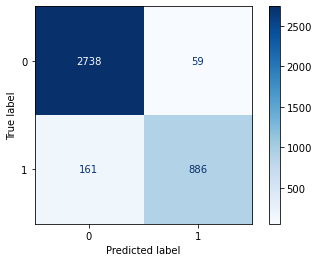

In [30]:
# Confusion Matrix Plot
metrics.plot_confusion_matrix(rf_model_non_verified, x_test_non_verified, y_test_non_verified, cmap = "Blues")
plt.show()

### verified - XGB

In [31]:
%%time

# Fit Model
weight_verified = verified_accounts_dataset['isBot'].value_counts()[0] / verified_accounts_dataset['isBot'].value_counts()[1]
xgb_classifier_verified = get_xgb_classifier(weight_verified)
xgb_model_verified = xgb_classifier_verified.fit(x_train_verified, y_train_verified)

Wall time: 861 ms


In [32]:
%%time

# y_prediction for the verified XGBoost model
y_pred_verified_xgb = xgb_model_verified.predict(x_test_verified)

Wall time: 8.23 ms


In [33]:
# Metrics
accuracy = metrics.accuracy_score(y_test_verified, y_pred_verified_xgb)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test_verified, y_pred_verified_xgb)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test_verified, y_pred_verified_xgb)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test_verified, y_pred_verified_xgb)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test_verified, y_pred_verified_xgb)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test_verified, y_pred_verified_xgb)
print(f'Recall: {recall}')
report = metrics.classification_report(y_test_verified, y_pred_verified_xgb)
print(f'Classification Report: \n {report}')

Accuracy: 0.8093023255813954
Log Loss: 6.586531278814333
ROC AUC: 0.7274633123689727
F1-score: 0.594059405940594
Precision: 0.625
Recall: 0.5660377358490566
Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.89      0.88       162
           1       0.62      0.57      0.59        53

    accuracy                           0.81       215
   macro avg       0.74      0.73      0.73       215
weighted avg       0.80      0.81      0.81       215



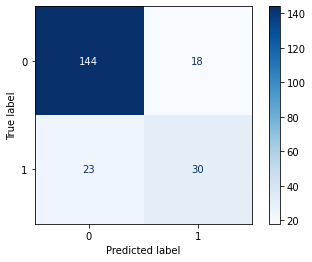

In [34]:
# Confusion Matrix Plot
metrics.plot_confusion_matrix(xgb_model_verified, x_test_verified, y_test_verified, cmap = "Blues")
plt.show()

### non-verified - XGB

In [108]:
%%time

# Fit Model
weight_non_verified = non_verified_accounts_dataset['isBot'].value_counts()[0] / non_verified_accounts_dataset['isBot'].value_counts()[1]
xgb_classifier_non_verified = get_xgb_classifier(weight_non_verified)
xgb_model_non_verified = xgb_classifier_non_verified.fit(x_train_non_verified, y_train_non_verified)

Wall time: 3.58 s


In [109]:
%%time

# y_prediction for the non verified XGBoost model
y_pred_non_verified_xgb = xgb_model_non_verified.predict(x_test_non_verified)

Wall time: 30.3 ms


In [110]:
# Metrics
accuracy = metrics.accuracy_score(y_test_non_verified, y_pred_non_verified_xgb)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test_non_verified, y_pred_non_verified_xgb)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test_non_verified, y_pred_non_verified_xgb)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test_non_verified, y_pred_non_verified_xgb)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test_non_verified, y_pred_non_verified_xgb)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test_non_verified, y_pred_non_verified_xgb)
print(f'Recall: {recall}')
report = metrics.classification_report(y_test_non_verified, y_pred_non_verified_xgb)
print(f'Classification Report: \n {report}')

Accuracy: 0.9430280957336108
Log Loss: 1.9677565031945519
ROC AUC: 0.919318829459453
F1-score: 0.8923832923832924
Precision: 0.9190283400809717
Recall: 0.8672397325692455
Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      2797
           1       0.92      0.87      0.89      1047

    accuracy                           0.94      3844
   macro avg       0.94      0.92      0.93      3844
weighted avg       0.94      0.94      0.94      3844



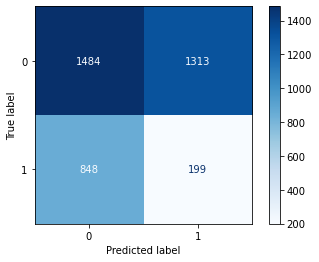

In [41]:
# Confusion Matrix Plot
metrics.plot_confusion_matrix(xgb_model_non_verified, x_test_non_verified, y_test_non_verified, cmap = "Blues")
plt.show()

## 02 protected
* Random Forest Classifier
* XGBoost Classifier

In [42]:
print("Number of Protected Accounts: " + str(len(metadata_dataset[metadata_dataset['protected'] == 1].index)))
print("Number of Non-Protected Accounts: " + str(len(metadata_dataset[metadata_dataset['protected'] == 0].index)))

protected_accounts_dataset = metadata_dataset[metadata_dataset['protected'] == 1]
non_protected_accounts_dataset = metadata_dataset[metadata_dataset['protected'] == 0]

# Getting X and y
x_protected = protected_accounts_dataset.drop(columns = ['isBot'])
y_protected = protected_accounts_dataset['isBot']

# Split into training and testing sets before scaling the variables and performing one hot encoding to avoid data leakage
x_train_protected, x_test_protected, y_train_protected, y_test_protected = train_test_split(x_protected, y_protected, test_size = 0.2, random_state=101)
print("Train set (verified):", x_train_protected.shape, y_train_protected.shape)
print("Test set (verified):", x_test_protected.shape, y_test_protected.shape)

scaler_protected = StandardScaler()
x_train_protected[numeric_variables] = scaler_protected.fit_transform(x_train_protected[numeric_variables])
x_test_protected[numeric_variables] = scaler_protected.transform(x_test_protected[numeric_variables])

# Getting X and y
x_non_protected = non_protected_accounts_dataset.drop(columns = ['isBot'])
y_non_protected = non_protected_accounts_dataset['isBot']

# Split into training and testing sets before scaling the variables and performing one hot encoding to avoid data leakage
x_train_non_protected, x_test_non_protected, y_train_non_protected, y_test_non_protected = train_test_split(x_non_protected, y_non_protected, test_size = 0.2, random_state=101)
print("Train set (non-verified):", x_train_non_protected.shape, y_train_non_protected.shape)
print("Test set (non-verified):", x_test_non_protected.shape, y_test_non_protected.shape)

scaler_non_protected = StandardScaler()
x_train_non_protected[numeric_variables] = scaler_non_protected.fit_transform(x_train_non_protected[numeric_variables])
x_test_non_protected[numeric_variables] = scaler_non_protected.transform(x_test_non_protected[numeric_variables])

Number of Protected Accounts: 2472
Number of Non-Protected Accounts: 17817
Train set (verified): (1977, 17) (1977,)
Test set (verified): (495, 17) (495,)
Train set (non-verified): (14253, 17) (14253,)
Test set (non-verified): (3564, 17) (3564,)


### protected - RF

In [43]:
%%time

# Fit Model
rf_model_protected = rf_classifier.fit(x_train_protected, np.ravel(y_train_protected))

Wall time: 36.7 ms


In [44]:
%%time

# y_prediction for the protected RF model
y_pred_protected_rf = rf_model_protected.predict(x_test_protected)

Wall time: 4.99 ms


In [45]:
# Metrics
accuracy = metrics.accuracy_score(y_test_protected, y_pred_protected_rf)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test_protected, y_pred_protected_rf)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test_protected, y_pred_protected_rf)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test_protected, y_pred_protected_rf)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test_protected, y_pred_protected_rf)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test_protected, y_pred_protected_rf)
print(f'Recall: {recall}')
report = metrics.classification_report(y_test_protected, y_pred_protected_rf)
print(f'Classification Report: \n {report}')

Accuracy: 0.9737373737373738
Log Loss: 0.9070870527696773
ROC AUC: 0.5504115226337448
F1-score: 0.13333333333333333
Precision: 0.16666666666666666
Recall: 0.1111111111111111
Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       486
           1       0.17      0.11      0.13         9

    accuracy                           0.97       495
   macro avg       0.58      0.55      0.56       495
weighted avg       0.97      0.97      0.97       495



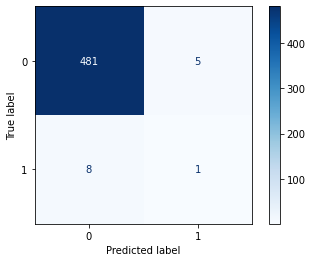

In [46]:
# Confusion Matrix Plot
metrics.plot_confusion_matrix(rf_model_protected, x_test_protected, y_test_protected, cmap = "Blues")
plt.show()

### non-protected - RF

In [47]:
%%time

# Fit Model
rf_model_non_protected = rf_classifier.fit(x_train_non_protected, np.ravel(y_train_non_protected))

Wall time: 264 ms


In [48]:
%%time

# y_prediction for the non protected RF model
y_pred_non_protected_rf = rf_model_non_protected.predict(x_test_non_protected)

Wall time: 8.33 ms


In [49]:
# Metrics
accuracy = metrics.accuracy_score(y_test_non_protected, y_pred_non_protected_rf)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test_non_protected, y_pred_non_protected_rf)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test_non_protected, y_pred_non_protected_rf)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test_non_protected, y_pred_non_protected_rf)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test_non_protected, y_pred_non_protected_rf)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test_non_protected, y_pred_non_protected_rf)
print(f'Recall: {recall}')
report = metrics.classification_report(y_test_non_protected, y_pred_non_protected_rf)
print(f'Classification Report: \n {report}')

Accuracy: 0.9262065095398428
Log Loss: 2.5487518981170973
ROC AUC: 0.9010416666666666
F1-score: 0.879080459770115
Precision: 0.9345063538611925
Recall: 0.8298611111111112
Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.97      0.95      2412
           1       0.93      0.83      0.88      1152

    accuracy                           0.93      3564
   macro avg       0.93      0.90      0.91      3564
weighted avg       0.93      0.93      0.92      3564



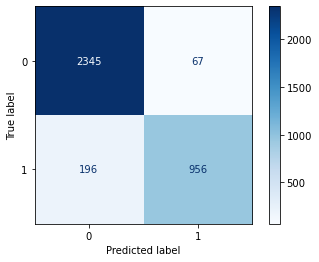

In [50]:
# Confusion Matrix Plot
metrics.plot_confusion_matrix(rf_model_non_protected, x_test_non_protected, y_test_non_protected, cmap = "Blues")
plt.show()

### protected - XGB

In [51]:
%%time

# Fit Model
weight_protected = protected_accounts_dataset['isBot'].value_counts()[0] / protected_accounts_dataset['isBot'].value_counts()[1]
xgb_classifier_protected = get_xgb_classifier(weight_protected)
xgb_model_protected = xgb_classifier_protected.fit(x_train_protected, np.ravel(y_train_protected))

Wall time: 167 ms


In [52]:
%%time

# y_prediction for the verified stack model
y_pred_protected_xgb = xgb_model_protected.predict(x_test_protected)

Wall time: 3.67 ms


In [53]:
# Metrics
accuracy = metrics.accuracy_score(y_test_protected, y_pred_protected_xgb)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test_protected, y_pred_protected_xgb)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test_protected, y_pred_protected_xgb)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test_protected, y_pred_protected_xgb)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test_protected, y_pred_protected_xgb)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test_protected, y_pred_protected_xgb)
print(f'Recall: {recall}')
report = metrics.classification_report(y_test_protected, y_pred_protected_xgb)
print(f'Classification Report: \n {report}')

Accuracy: 0.9757575757575757
Log Loss: 0.8373117469213729
ROC AUC: 0.6059670781893004
F1-score: 0.25
Precision: 0.2857142857142857
Recall: 0.2222222222222222
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       486
           1       0.29      0.22      0.25         9

    accuracy                           0.98       495
   macro avg       0.64      0.61      0.62       495
weighted avg       0.97      0.98      0.97       495



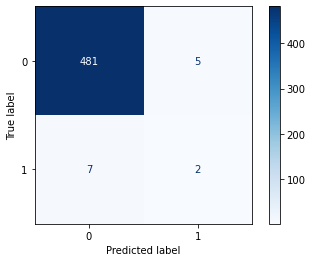

In [54]:
# Confusion Matrix Plot
metrics.plot_confusion_matrix(xgb_model_protected, x_test_protected, y_test_protected, cmap = "Blues")
plt.show()

### non-protected - XGB

In [55]:
%%time

# Fit Model
weight_non_protected = non_protected_accounts_dataset['isBot'].value_counts()[0] / non_protected_accounts_dataset['isBot'].value_counts()[1]
xgb_classifier_non_protected = get_xgb_classifier(weight_non_protected)
xgb_model_non_protected = xgb_classifier_non_protected.fit(x_train_non_protected, np.ravel(y_train_non_protected))

Wall time: 1.86 s


In [58]:
%%time

# y_prediction for the non protected RF model
y_pred_non_protected_xgb = xgb_model_non_protected.predict(x_test_non_protected)

Wall time: 9.98 ms


In [59]:
# Metrics
accuracy = metrics.accuracy_score(y_test_non_protected, y_pred_non_protected_xgb)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test_non_protected, y_pred_non_protected_xgb)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test_non_protected, y_pred_non_protected_xgb)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test_non_protected, y_pred_non_protected_xgb)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test_non_protected, y_pred_non_protected_xgb)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test_non_protected, y_pred_non_protected_xgb)
print(f'Recall: {recall}')
report = metrics.classification_report(y_test_non_protected, y_pred_non_protected_xgb)
print(f'Classification Report: \n {report}')

Accuracy: 0.9323793490460157
Log Loss: 2.335553164354709
ROC AUC: 0.9142179726368159
F1-score: 0.8918797667115297
Precision: 0.9229340761374187
Recall: 0.8628472222222222
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.97      0.95      2412
           1       0.92      0.86      0.89      1152

    accuracy                           0.93      3564
   macro avg       0.93      0.91      0.92      3564
weighted avg       0.93      0.93      0.93      3564



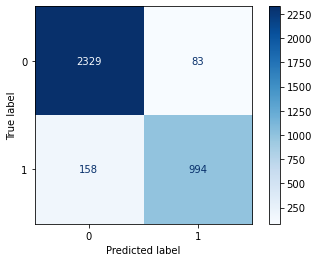

In [60]:
# Confusion Matrix Plot
metrics.plot_confusion_matrix(xgb_model_non_protected, x_test_non_protected, y_test_non_protected, cmap = "Blues")
plt.show()

## 03 followers_count
* Random Forest Classifier
* XGBoost Classifier

Upper Quartile: 1381
Train set (high): (4056, 17) (4056,)
Test set (high): (1014, 17) (1014,)
Train set (low): (12175, 17) (12175,)
Test set (low): (3044, 17) (3044,)


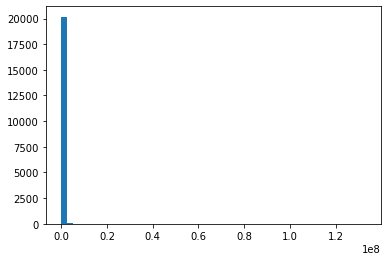

In [67]:
plot = plt.hist(metadata_dataset['followers_count'], bins=50)
print("Upper Quartile: " + str(int(metadata_dataset['followers_count'].describe()['75%'])))

high_followers_dataset = metadata_dataset[metadata_dataset['followers_count'] > 1381]
low_followers_dataset = metadata_dataset[metadata_dataset['followers_count'] <= 1381]

# Getting X and y
x_high = high_followers_dataset.drop(columns = ['isBot'])
y_high = high_followers_dataset['isBot']

# Split into training and testing sets before scaling the variables and performing one hot encoding to avoid data leakage
x_train_high, x_test_high, y_train_high, y_test_high = train_test_split(x_high, y_high, test_size = 0.2, random_state=101)
print("Train set (high):", x_train_high.shape, y_train_high.shape)
print("Test set (high):", x_test_high.shape, y_test_high.shape)

scaler_high = StandardScaler()
x_train_high[numeric_variables] = scaler_high.fit_transform(x_train_high[numeric_variables])
x_test_high[numeric_variables] = scaler_high.transform(x_test_high[numeric_variables])

# Getting X and y
x_low = low_followers_dataset.drop(columns = ['isBot'])
y_low = low_followers_dataset['isBot']

# Split into training and testing sets before scaling the variables and performing one hot encoding to avoid data leakage
x_train_low, x_test_low, y_train_low, y_test_low = train_test_split(x_low, y_low, test_size = 0.2, random_state=101)
print("Train set (low):", x_train_low.shape, y_train_low.shape)
print("Test set (low):", x_test_low.shape, y_test_low.shape)

scaler_low = StandardScaler()
x_train_low[numeric_variables] = scaler_low.fit_transform(x_train_low[numeric_variables])
x_test_low[numeric_variables] = scaler_low.transform(x_test_low[numeric_variables])

### followers_count > 75% - RF

In [68]:
%%time

# Fit Model
rf_model_high = rf_classifier.fit(x_train_high, np.ravel(y_train_high))

Wall time: 134 ms


In [69]:
%%time

# y_prediction for the high followers RF model
y_pred_high_rf = rf_model_high.predict(x_test_high)

Wall time: 7.77 ms


In [70]:
# Metrics
accuracy = metrics.accuracy_score(y_test_high, y_pred_high_rf)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test_high, y_pred_high_rf)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test_high, y_pred_high_rf)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test_high, y_pred_high_rf)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test_high, y_pred_high_rf)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test_high, y_pred_high_rf)
print(f'Recall: {recall}')
report = metrics.classification_report(y_test_high, y_pred_high_rf)
print(f'Classification Report: \n {report}')

Accuracy: 0.8865877712031558
Log Loss: 3.91714642182185
ROC AUC: 0.8092861757105944
F1-score: 0.7344110854503465
Precision: 0.8238341968911918
Recall: 0.6625
Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.96      0.93       774
           1       0.82      0.66      0.73       240

    accuracy                           0.89      1014
   macro avg       0.86      0.81      0.83      1014
weighted avg       0.88      0.89      0.88      1014



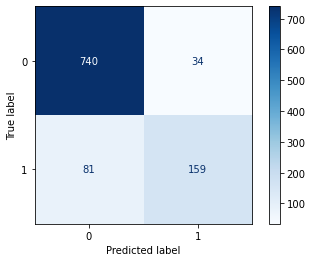

In [71]:
# Confusion Matrix Plot
metrics.plot_confusion_matrix(rf_model_high, x_test_high, y_test_high, cmap = "Blues")
plt.show()

### followers_count <= 75% - RF

In [72]:
%%time

# Fit Model
rf_model_low = rf_classifier.fit(x_train_low, np.ravel(y_train_low))

Wall time: 236 ms


In [73]:
%%time

# y_prediction for the low followers RF model
y_pred_low_rf = rf_model_low.predict(x_test_low)

Wall time: 12.3 ms


In [74]:
# Metrics
accuracy = metrics.accuracy_score(y_test_low, y_pred_low_rf)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test_low, y_pred_low_rf)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test_low, y_pred_low_rf)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test_low, y_pred_low_rf)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test_low, y_pred_low_rf)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test_low, y_pred_low_rf)
print(f'Recall: {recall}')
report = metrics.classification_report(y_test_low, y_pred_low_rf)
print(f'Classification Report: \n {report}')

Accuracy: 0.9497371879106439
Log Loss: 1.7360239081288578
ROC AUC: 0.9231820282305496
F1-score: 0.9082183563287343
Precision: 0.9618805590851334
Recall: 0.8602272727272727
Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      2164
           1       0.96      0.86      0.91       880

    accuracy                           0.95      3044
   macro avg       0.95      0.92      0.94      3044
weighted avg       0.95      0.95      0.95      3044



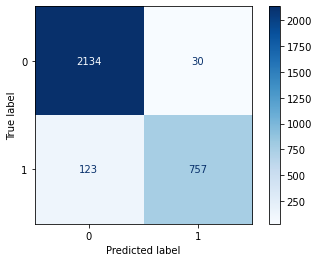

In [75]:
# Confusion Matrix Plot
metrics.plot_confusion_matrix(rf_model_low, x_test_low, y_test_low, cmap = "Blues")
plt.show()

### followers_count > 75% - XGB

In [76]:
%%time

# Fit Model
weight_high = high_followers_dataset['isBot'].value_counts()[0] / high_followers_dataset['isBot'].value_counts()[1]
xgb_classifier_high = get_xgb_classifier(weight_high)
xgb_model_high = xgb_classifier_high.fit(x_train_high, np.ravel(y_train_high))

Wall time: 904 ms


In [77]:
%%time

# y_prediction for the high followers XGBoost model
y_pred_high_xgb = xgb_model_high.predict(x_test_high)

Wall time: 9.38 ms


In [78]:
# Metrics
accuracy = metrics.accuracy_score(y_test_high, y_pred_high_xgb)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test_high, y_pred_high_xgb)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test_high, y_pred_high_xgb)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test_high, y_pred_high_xgb)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test_high, y_pred_high_xgb)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test_high, y_pred_high_xgb)
print(f'Recall: {recall}')
report = metrics.classification_report(y_test_high, y_pred_high_xgb)
print(f'Classification Report: \n {report}')

Accuracy: 0.873767258382643
Log Loss: 4.359970172780591
ROC AUC: 0.8166989664082688
F1-score: 0.7264957264957265
Precision: 0.7456140350877193
Recall: 0.7083333333333334
Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.93      0.92       774
           1       0.75      0.71      0.73       240

    accuracy                           0.87      1014
   macro avg       0.83      0.82      0.82      1014
weighted avg       0.87      0.87      0.87      1014



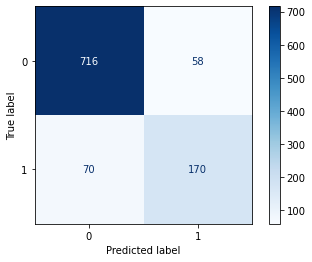

In [79]:
# Confusion Matrix Plot
metrics.plot_confusion_matrix(xgb_model_high, x_test_high, y_test_high, cmap = "Blues")
plt.show()

### followers_count <= 75% - XGB

In [81]:
%%time

# Fit Model
weight_low = low_followers_dataset['isBot'].value_counts()[0] / low_followers_dataset['isBot'].value_counts()[1]
xgb_classifier_low = get_xgb_classifier(weight_low)
xgb_model_low = xgb_classifier_low.fit(x_train_low, np.ravel(y_train_low))

Wall time: 1.8 s


In [82]:
%%time

# y_prediction for the low followers XGBoost model
y_pred_low_xgb = xgb_model_low.predict(x_test_low)

Wall time: 11 ms


In [83]:
# Metrics
accuracy = metrics.accuracy_score(y_test_low, y_pred_low_xgb)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test_low, y_pred_low_xgb)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test_low, y_pred_low_xgb)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test_low, y_pred_low_xgb)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test_low, y_pred_low_xgb)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test_low, y_pred_low_xgb)
print(f'Recall: {recall}')
report = metrics.classification_report(y_test_low, y_pred_low_xgb)
print(f'Classification Report: \n {report}')

Accuracy: 0.9507227332457293
Log Loss: 1.7019896317700771
ROC AUC: 0.9316291379600067
F1-score: 0.912280701754386
Precision: 0.9397590361445783
Recall: 0.8863636363636364
Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.98      0.97      2164
           1       0.94      0.89      0.91       880

    accuracy                           0.95      3044
   macro avg       0.95      0.93      0.94      3044
weighted avg       0.95      0.95      0.95      3044



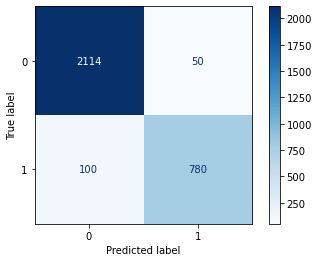

In [84]:
# Confusion Matrix Plot
metrics.plot_confusion_matrix(xgb_model_low, x_test_low, y_test_low, cmap = "Blues")
plt.show()

## 04 has_profile_image
* Random Forest Classifier
* XGBoost Classifier

In [86]:
print("Number of has_prof_img Accounts: " + str(len(metadata_dataset[metadata_dataset['has_profile_image'] == 1].index)))
print("Number of no_prof_img Accounts: " + str(len(metadata_dataset[metadata_dataset['has_profile_image'] == 0].index)))

has_prof_img_dataset = metadata_dataset[metadata_dataset['has_profile_image'] == 1]
no_prof_img_dataset = metadata_dataset[metadata_dataset['has_profile_image'] == 0]

# Getting X and y
x_has_prof_img = has_prof_img_dataset.drop(columns = ['isBot'])
y_has_prof_img = has_prof_img_dataset['isBot']

# Split into training and testing sets before scaling the variables and performing one hot encoding to avoid data leakage
x_train_has_prof_img, x_test_has_prof_img, y_train_has_prof_img, y_test_has_prof_img = train_test_split(x_has_prof_img, y_has_prof_img, test_size = 0.2, random_state=101)
print("Train set (has profile image):", x_train_has_prof_img.shape, y_train_has_prof_img.shape)
print("Test set (has profile image):", x_test_has_prof_img.shape, y_test_has_prof_img.shape)

scaler_has_prof_img = StandardScaler()
x_train_has_prof_img[numeric_variables] = scaler_has_prof_img.fit_transform(x_train_has_prof_img[numeric_variables])
x_test_has_prof_img[numeric_variables] = scaler_has_prof_img.transform(x_test_has_prof_img[numeric_variables])

# Getting X and y
x_no_prof_img = no_prof_img_dataset.drop(columns = ['isBot'])
y_no_prof_img = no_prof_img_dataset['isBot']

# Split into training and testing sets before scaling the variables and performing one hot encoding to avoid data leakage
x_train_no_prof_img, x_test_no_prof_img, y_train_no_prof_img, y_test_no_prof_img = train_test_split(x_no_prof_img, y_no_prof_img, test_size = 0.2, random_state=101)
print("Train set (no profile image):", x_train_no_prof_img.shape, y_train_no_prof_img.shape)
print("Test set (no profile image):", x_test_no_prof_img.shape, y_test_no_prof_img.shape)

scaler_no_prof_img = StandardScaler()
x_train_no_prof_img[numeric_variables] = scaler_no_prof_img.fit_transform(x_train_no_prof_img[numeric_variables])
x_test_no_prof_img[numeric_variables] = scaler_no_prof_img.transform(x_test_no_prof_img[numeric_variables])

Number of has_prof_img Accounts: 19788
Number of no_prof_img Accounts: 501
Train set (has profile image): (15830, 17) (15830,)
Test set (has profile image): (3958, 17) (3958,)
Train set (no profile image): (400, 17) (400,)
Test set (no profile image): (101, 17) (101,)


### has_profile_image - RF

In [87]:
%%time

# Fit Model
rf_model_has_prof_img = rf_classifier.fit(x_train_has_prof_img, np.ravel(y_train_has_prof_img))

Wall time: 354 ms


In [88]:
%%time

# y_prediction for the has_profile_img RF model
y_pred_has_prof_img_rf = rf_model_has_prof_img.predict(x_test_has_prof_img)

Wall time: 12 ms


In [89]:
# Metrics
accuracy = metrics.accuracy_score(y_test_has_prof_img, y_pred_has_prof_img_rf)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test_has_prof_img, y_pred_has_prof_img_rf)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test_has_prof_img, y_pred_has_prof_img_rf)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test_has_prof_img, y_pred_has_prof_img_rf)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test_has_prof_img, y_pred_has_prof_img_rf)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test_has_prof_img, y_pred_has_prof_img_rf)
print(f'Recall: {recall}')
report = metrics.classification_report(y_test_has_prof_img, y_pred_has_prof_img_rf)
print(f'Classification Report: \n {report}')

Accuracy: 0.9365841334007075
Log Loss: 2.190318355576293
ROC AUC: 0.900465277609725
F1-score: 0.8755577590480913
Precision: 0.9373673036093418
Recall: 0.8213953488372093
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      2883
           1       0.94      0.82      0.88      1075

    accuracy                           0.94      3958
   macro avg       0.94      0.90      0.92      3958
weighted avg       0.94      0.94      0.94      3958



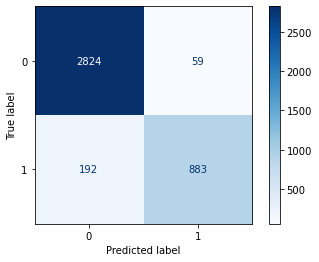

In [90]:
# Confusion Matrix Plot
metrics.plot_confusion_matrix(rf_model_has_prof_img, x_test_has_prof_img, y_test_has_prof_img, cmap = "Blues")
plt.show()

### no_profile_image - RF

In [91]:
%%time

# Fit Model
rf_model_no_prof_img = rf_classifier.fit(x_train_no_prof_img, np.ravel(y_train_no_prof_img))

Wall time: 18.4 ms


In [92]:
%%time

# y_prediction for the no_profile_image RF model
y_pred_no_prof_img_rf = rf_model_no_prof_img.predict(x_test_no_prof_img)

Wall time: 6.45 ms


In [93]:
# Metrics
accuracy = metrics.accuracy_score(y_test_no_prof_img, y_pred_no_prof_img_rf)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test_no_prof_img, y_pred_no_prof_img_rf)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test_no_prof_img, y_pred_no_prof_img_rf)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test_no_prof_img, y_pred_no_prof_img_rf)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test_no_prof_img, y_pred_no_prof_img_rf)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test_no_prof_img, y_pred_no_prof_img_rf)
print(f'Recall: {recall}')
report = metrics.classification_report(y_test_no_prof_img, y_pred_no_prof_img_rf)
print(f'Classification Report: \n {report}')

Accuracy: 0.900990099009901
Log Loss: 3.419728332016713
ROC AUC: 0.8672619047619048
F1-score: 0.7727272727272727
Precision: 0.7391304347826086
Recall: 0.8095238095238095
Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.93      0.94        80
           1       0.74      0.81      0.77        21

    accuracy                           0.90       101
   macro avg       0.84      0.87      0.85       101
weighted avg       0.91      0.90      0.90       101



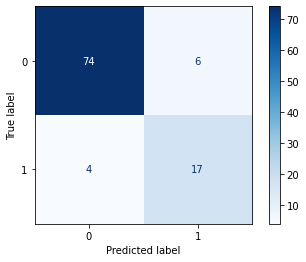

In [94]:
# Confusion Matrix Plot
metrics.plot_confusion_matrix(rf_model_no_prof_img, x_test_no_prof_img, y_test_no_prof_img, cmap = "Blues")
plt.show()

### has_profile_image - XGB

In [95]:
%%time

# Fit Model
weight_has_prof_img = has_prof_img_dataset['isBot'].value_counts()[0] / has_prof_img_dataset['isBot'].value_counts()[1]
xgb_classifier_has_prof_img = get_xgb_classifier(weight_has_prof_img)
xgb_model_has_prof_img = xgb_classifier_has_prof_img.fit(x_train_has_prof_img, y_train_has_prof_img)

Wall time: 3.63 s


In [96]:
%%time

# y_prediction for the low followers XGBoost model
y_pred_has_prof_img_xgb = xgb_model_has_prof_img.predict(x_test_has_prof_img)

Wall time: 32 ms


In [97]:
# Metrics
accuracy = metrics.accuracy_score(y_test_has_prof_img, y_pred_has_prof_img_rf)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test_has_prof_img, y_pred_has_prof_img_rf)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test_has_prof_img, y_pred_has_prof_img_rf)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test_has_prof_img, y_pred_has_prof_img_rf)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test_has_prof_img, y_pred_has_prof_img_rf)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test_has_prof_img, y_pred_has_prof_img_rf)
print(f'Recall: {recall}')
report = metrics.classification_report(y_test_has_prof_img, y_pred_has_prof_img_rf)
print(f'Classification Report: \n {report}')

Accuracy: 0.9365841334007075
Log Loss: 2.190318355576293
ROC AUC: 0.900465277609725
F1-score: 0.8755577590480913
Precision: 0.9373673036093418
Recall: 0.8213953488372093
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      2883
           1       0.94      0.82      0.88      1075

    accuracy                           0.94      3958
   macro avg       0.94      0.90      0.92      3958
weighted avg       0.94      0.94      0.94      3958



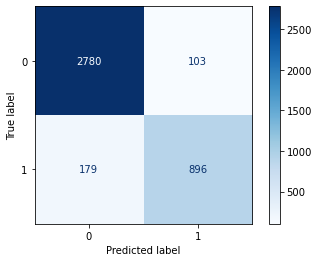

In [98]:
# Confusion Matrix Plot
metrics.plot_confusion_matrix(xgb_model_has_prof_img, x_test_has_prof_img, y_test_has_prof_img, cmap = "Blues")
plt.show()

### no_profile_image - XGB

In [104]:
%%time

# Fit Model
weight_no_prof_img = no_prof_img_dataset['isBot'].value_counts()[0] / no_prof_img_dataset['isBot'].value_counts()[1]
xgb_classifier_no_prof_img = get_xgb_classifier(weight_no_prof_img)
xgb_model_no_prof_img = xgb_classifier_no_prof_img.fit(x_train_no_prof_img, y_train_no_prof_img)

Wall time: 94.8 ms


In [105]:
%%time

# y_prediction for the no_profile_image RF model
y_pred_no_prof_img_xgb = xgb_model_no_prof_img.predict(x_test_no_prof_img)

Wall time: 5.02 ms


In [106]:
# Metrics
accuracy = metrics.accuracy_score(y_test_no_prof_img, y_pred_no_prof_img_xgb)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test_no_prof_img, y_pred_no_prof_img_xgb)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test_no_prof_img, y_pred_no_prof_img_xgb)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test_no_prof_img, y_pred_no_prof_img_xgb)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test_no_prof_img, y_pred_no_prof_img_xgb)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test_no_prof_img, y_pred_no_prof_img_xgb)
print(f'Recall: {recall}')
report = metrics.classification_report(y_test_no_prof_img, y_pred_no_prof_img_xgb)
print(f'Classification Report: \n {report}')

Accuracy: 0.9108910891089109
Log Loss: 3.0777681657050255
ROC AUC: 0.9086309523809523
F1-score: 0.8085106382978723
Precision: 0.7307692307692307
Recall: 0.9047619047619048
Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.91      0.94        80
           1       0.73      0.90      0.81        21

    accuracy                           0.91       101
   macro avg       0.85      0.91      0.88       101
weighted avg       0.92      0.91      0.91       101



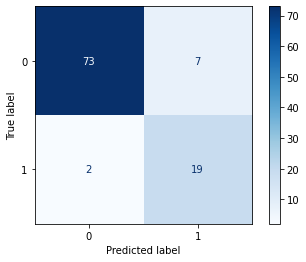

In [107]:
# Confusion Matrix Plot
metrics.plot_confusion_matrix(xgb_model_no_prof_img, x_test_no_prof_img, y_test_no_prof_img, cmap = "Blues")
plt.show()